# Analysis of Interactions between Variables and Extreme Weather Events

Now we will plot the interactions between extreme weather events (i.e., floods and cyclones) and our variables for each site. We will being by using Hervey bay as an example and then provide custom functions to apply this to all sites and all variables relevant to our study.

In [18]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime
import datetime as dt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (10,5)
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [2]:
# Reading the netCDF data for Cairns
Cairns_ds = xr.open_mfdataset('Cairns/Cairns*.nc')
# Reading the netCDF data for Townsville
Townsville_ds = xr.open_mfdataset('Townsville/Townsville*.nc')
# Reading the netCDF data for Hervey bay
HerveyBay_ds = xr.open_mfdataset('HerveyBay/HerveyBay*.nc')
# Reading the netCDF data for Moreton bay
MoretonBay_ds = xr.open_mfdataset('MoretonBay/MoretonBay*.nc')

In [3]:
# Reading the cyclone data
url = 'GBR_cyclones.csv'
cyclones = pd.read_csv(url, parse_dates=['ISO_TIME'], usecols=range(13), index_col='SID',
                 skiprows=[1], na_values=[' ', 'NOT_NAMED'],
                 keep_default_na=False, dtype={'NAME': str})
cyclones

,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,CATEGORY
SID,,,,,,,,,,,,
2011023S16147,2011,6,SP,EA,ANTHONY,2011-01-22 15:00:00,NR,-15.5881,147.218,,,
2011023S16147,2011,6,SP,EA,ANTHONY,2011-01-22 18:00:00,TS,-15.5000,147.800,,,
2011023S16147,2011,6,SP,EA,ANTHONY,2011-01-22 21:00:00,TS,-15.4618,148.348,,,
2011023S16147,2011,6,SP,EA,ANTHONY,2011-01-23 00:00:00,TS,-15.4600,148.980,30.0,997.0,tropical depression
2011023S16147,2011,6,SP,EA,ANTHONY,2011-01-23 03:00:00,TS,-15.5585,149.895,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 06:00:00,NR,-41.4000,165.700,40.0,982.0,tropical storm
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 09:00:00,NR,-41.8348,165.489,,,
2014092S11159,2014,24,SP,MM,ITA,2014-04-18 12:00:00,NR,-42.3000,165.400,40.0,984.0,tropical storm


We extract the data for each cyclone impacting the GBR. We do this because some regions of our study were not impacted by particular cyclones so this allows us to select the relevant cyclones to plot for each region. It also allows us to assign a different colour to each cyclone when plotting so that we can easily distinguish them.

In [4]:
def cycData(cycName):
    
    # Specifying columns we don't need by index number
    cols = [0, 1, 2, 3, 4, 6, 9, 10]
    
    # Converts the string of the cyclone name into upper case which is the format the names are in in the dataframe
    cycNameUpper = cycName.upper()
    
    # Extracting specified cyclone data, dropping specified columns
    df_cycName = cyclones[cyclones["NAME"].str.contains(cycNameUpper) == True].drop(cyclones.columns[cols],
                         axis=1) # axis=1 indicates we are dropping from the columns rather than the index
    
    return df_cycName

# Calling the function
Ita = cycData('Ita')
Anthony = cycData('Anthony')
Oswald = cycData('Oswald')
Dylan = cycData('Dylan')
Hadi = cycData('Hadi')
Jasmine = cycData('Jasmine')
Sandra = cycData('Sandra')
Tim = cycData('Tim')
Yasi = cycData('Yasi')

We also want to plot the floods that affected our regions onto our time series. Rather than plot flood incidence at the bottom of our time series along the x-axis as we will do with our cyclones, it will be much more helpful to plot the flood data directly onto the relevant min or max values for our variables. This allows us to easily see exactly where and how each of our variables are impacted by the floods. In order to do this, we need to determine the dates when floods occur for each region. Then we will extract the data for these dates from our variables to determine which y-values we will use to plot our floods. We will plot our floods on the line where there is the most variation in the data. For nitrogen, light intensity and seagrass density, this is the maximum line. For salinity, this is the minimum line.

First we compute the min, mean and max values for our site with 30-day rolling means:

In [5]:
max_region = HerveyBay_ds.max(dim=('latitude', 'longitude'))
month_max_region = max_region.rolling(time=30,center=True).mean() # 30-day interval
min_region = HerveyBay_ds.min(dim=('latitude', 'longitude'))
month_min_region = min_region.rolling(time=30,center=True).mean()
mean_region = HerveyBay_ds.mean(dim=('latitude', 'longitude'))
month_mean_region = mean_region.rolling(time=30,center=True).mean()

Then we convert our xarray dataset to a pandas dataframe and reset the index:

In [6]:
max_df = max_region.to_dataframe().reset_index()
min_df = min_region.to_dataframe().reset_index()

Now we convert the time column from datetime to string data type:

In [7]:
max_df['time'] = max_df['time'].dt.strftime('%Y-%m-%d')
min_df['time'] = min_df['time'].dt.strftime('%Y-%m-%d')

In [8]:
max_df.dtypes # Returns the data type for each column. 
# We are checking to see if the data type has changed from datetime to a string (object in pandas)

time               object
TOTAL_NITROGEN    float32
temp              float32
salinity          float32
light             float32
seagrass          float32
dtype: object

This allows us to extract the rows by specifying particular dates.

In [9]:
# Extract the data for the relevant flood dates for Hervey bay. All dates are derived from the BOM.
max_floods = max_df[max_df["time"].str.contains("2011-01-08|2012-02-02|2012-03-04|2013-01-25|2013-03-04|2014-01-25|2014-03-30|2014-12-12") == True]
min_floods = min_df[min_df["time"].str.contains("2011-01-08|2012-02-02|2012-03-04|2013-01-25|2013-03-04|2014-01-25|2014-03-30|2014-12-12") == True]

Now we drop the rows that we don't need for each dataset and convert our 'time' column back to datetime format so that we can plot it:

In [10]:
# We plot at the maximum y-values for nitrogen, light intensity and seagrass so we drop the other columns; 
# The temperature variable is excluded from our study so we also drop this column
max_floods = max_floods.drop(['salinity', 'temp'], axis=1)

# For salinity, we plot at the minimum y-values so we drop all other columns 
min_floods = min_floods.drop(['TOTAL_NITROGEN', 'temp', 'light', 'seagrass'], axis=1)

# Converting the 'time' column back to datetime format
max_floods["time"] = pd.to_datetime(min_floods["time"])
min_floods["time"] = pd.to_datetime(min_floods["time"])

Now we merge the two datasets:

In [11]:
# The datasets are merged based on the column they both have in common, i.e., 'time'
HerveyFloods = pd.merge_asof(max_floods, min_floods, on='time')
HerveyFloods

,time,TOTAL_NITROGEN,light,seagrass,salinity
0,2011-01-08,626.847595,32.775494,1.318836,5.854748
1,2012-02-02,794.651001,123.734558,1.254680,20.712652
2,2012-03-04,653.748291,44.080982,1.144655,21.773315
3,2013-01-25,459.610382,41.889378,1.028025,33.869408
4,2013-03-04,1261.249023,17.934196,0.591529,7.132458
5,2014-01-25,165.573212,93.587746,1.730847,35.486576
6,2014-03-30,466.053497,58.419159,1.508923,26.928896
7,2014-12-12,209.814499,42.101913,2.672721,35.317760


To perform this in one function for any site from our study, I have created a custom function that extracts the data for each variable based on the floods that impacted the specified region. This flood data was derived from the Bureau of Meteorology's [detailed reports for notable Queensland floods](http://www.bom.gov.au/qld/flood/fld_reports/reports.shtml), particularly for the floods that were induced by cyclones and the severe flood seasons; and from the [Queensland flood summary page from 2010 onwards](http://www.bom.gov.au/qld/flood/fld_history/floodsum_2010.shtml).

In [5]:
def getFloodVar(site_name):
    
    '''
    This function extracts the variable data for the flood start dates from the 
    floods that are relevant to each site specified by name (site_name).    
    '''
    # Capitalise only the first letter of the provided site name
    sName_cap = site_name.capitalize()
    
    # Using the specified site name to get the required datasets
    if sName_cap == 'Cairns':
        site_ds = Cairns_ds
    elif sName_cap == 'Townsville':
        site_ds = Townsville_ds
    elif sName_cap == 'Hervey bay':
        site_ds = HerveyBay_ds
    elif sName_cap == 'Moreton bay':
        site_ds = MoretonBay_ds  
    
    # Computing min, mean and max values and rolling means
    max_region = site_ds.max(dim=('latitude', 'longitude'))
    month_max_region = max_region.rolling(time=30,center=True).mean() # 30-day interval
    min_region = site_ds.min(dim=('latitude', 'longitude'))
    month_min_region = min_region.rolling(time=30,center=True).mean()
    mean_region = site_ds.mean(dim=('latitude', 'longitude'))
    month_mean_region = mean_region.rolling(time=30,center=True).mean()
    
    # Convert the xarray dataset to a pandas dataframe and reset the index:
    max_df = max_region.to_dataframe().reset_index()
    min_df = min_region.to_dataframe().reset_index()
    
    # Convert the time column from datetime to string data type
    max_df['time'] = max_df['time'].dt.strftime('%Y-%m-%d')
    min_df['time'] = min_df['time'].dt.strftime('%Y-%m-%d')
    
    # Extract the data for the particular dates
    if sName_cap == 'Cairns':
        max_floods = max_df[max_df["time"].str.contains("2011-02-03|2011-06-29|2011-10-22|2012-03-15|2012-07-10|2013-01-23|2013-07-07|2014-02-11|2014-04-11|2013-08-01") == True]
        min_floods = min_df[min_df["time"].str.contains("2011-02-03|2011-06-29|2011-10-22|2012-03-15|2012-07-10|2013-01-23|2013-07-07|2014-02-11|2014-04-11|2013-08-01") == True]
          
    elif sName_cap == 'Townsville':
        max_floods = max_df[max_df["time"].str.contains("2011-02-02|2012-01-26|2012-03-15|2013-01-22|2014-02-17|2014-04-12") == True]
        min_floods = min_df[min_df["time"].str.contains("2011-02-02|2012-01-26|2012-03-15|2013-01-22|2014-02-17|2014-04-12") == True]

    elif sName_cap == 'Hervey bay':
        max_floods = max_df[max_df["time"].str.contains("2011-01-08|2012-02-02|2012-03-04|2013-01-25|2013-03-04|2014-01-25|2014-03-30|2014-12-12") == True]
        min_floods = min_df[min_df["time"].str.contains("2011-01-08|2012-02-02|2012-03-04|2013-01-25|2013-03-04|2014-01-25|2014-03-30|2014-12-12") == True]
        
    elif sName_cap == 'Moreton bay':
        max_floods = max_df[max_df["time"].str.contains("2011-01-07|2012-01-24|2012-02-24|2012-03-05|2012-03-21|2012-06-02|2013-01-27|2013-02-25|2014-03-25") == True]
        min_floods = min_df[min_df["time"].str.contains("2011-01-07|2012-01-24|2012-02-24|2012-03-05|2012-03-21|2012-06-02|2013-01-27|2013-02-25|2014-03-25") == True]
        
    # We require the maximum y-values for nitrogen, light intensity and seagrass for plotting so we drop the other columns; 
    # The temperature variable is excluded from our study so this column is also dropped
    max_floods = max_floods.drop(['salinity', 'temp'], axis=1)

    # For salinity, the minimum y-values are required for plotting so we drop all other columns 
    min_floods = min_floods.drop(['TOTAL_NITROGEN', 'temp', 'light', 'seagrass'], axis=1)

    # Converting the 'time' column back to datetime format
    max_floods["time"] = pd.to_datetime(min_floods["time"])
    min_floods["time"] = pd.to_datetime(min_floods["time"])
    
    # The datasets are merged based on the column they both have in common, i.e., 'time'
    SiteFloods = pd.merge_asof(max_floods, min_floods, on='time')
    
    return SiteFloods

Calling the function for each site:

In [6]:
HerveyFloods = getFloodVar('Hervey bay')
CairnsFloods = getFloodVar('Cairns')
MoretonFloods = getFloodVar('Moreton bay')
TownsvilleFloods = getFloodVar('Townsville')

The flood data is ready for plotting. Now we will create a dataframe for the cyclones at Hervey bay that contains only the relevant cyclones and the y-values needed to plot the cyclones at the bottom of the plot along the x-axis.

In [22]:
herveyBay_cyclones = {
    'cyc_name': ['TC Anthony', 'TC Yasi', 'TC Jasmine', 'TC Oswald', 'TC Sandra', 'TC Dylan', 'TC Hadi', 'TC Ita'],
    'cyc_x': [Anthony["ISO_TIME"][0], # We plot at the recorded beginning of the cyclone
              Yasi["ISO_TIME"][-1], # Since TCs Anthony and Yasi overlap, we plot the last recorded time of Yasi instead
              Jasmine["ISO_TIME"][0], 
              Oswald["ISO_TIME"][0],
              Sandra["ISO_TIME"][0], 
              Dylan["ISO_TIME"][0], 
              Hadi["ISO_TIME"][0], 
              Ita["ISO_TIME"][0]],
    'cyc_y': [-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1], # y-values; we will plot cyclones at the bottom of y-axis
    'cyc_y_salinity': [-1,-1,-1,-1,-1,-1,-1,-1], # the y values need to be a little lower for light and salinity
    'cyc_y_light': [-7,-7,-7,-7,-7,-7,-7,-7],

}

# We make this into a dataframe
herveyCyc_df = pd.DataFrame(herveyBay_cyclones, columns = ['cyc_name', 'cyc_x', 'cyc_y', 'cyc_y_salinity', 'cyc_y_light'])

Plotting for the variable *nitrogen*:

NameError: name 'HerveyFloods' is not defined

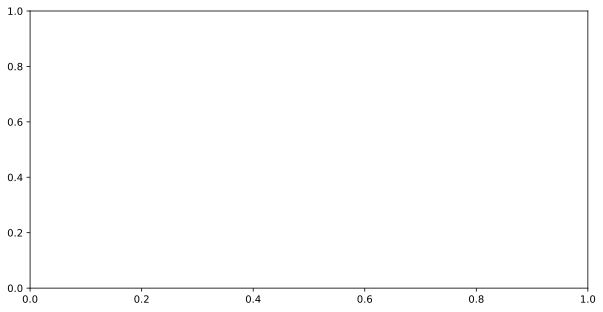

In [27]:
fig, ax1 = plt.subplots(figsize=(10,5))

colors = {'TC Anthony': '#c88efa', 'TC Yasi': '#ff737d', 'TC Jasmine': '#ffac75', 'TC Oswald': '#dfc7a7', 
          'TC Sandra': '#c1df90','TC Tim': '#4D8C57','TC Dylan': '#91DDF2', 'TC Hadi': '#8BC6FC', 'TC Ita': '#85A1F2'}

ax1.plot(HerveyFloods.time, HerveyFloods.TOTAL_NITROGEN,
         'o', color='r', label='floods', markersize=5,
         zorder=0) # 0 zorder plots at the bottom layer

# Plotting the incidence of each relevant cyclone at the bottom of the plot
#ax1.plot(herveyCyc_df.cyc_x, herveyCyc_df.cyc_y, '*', color=str(herveyCyc_df.cyc_color), markersize=9, 
 #        label=str(herveyCyc_df.cyc_name), zorder=0)

herveyCyc_df['x'], herveyCyc_df['y'] = herveyCyc_df['cyc_x'], herveyCyc_df['cyc_y']

for cyc_name in list(herveyCyc_df['cyc_name'].unique()):
    ax1.scatter(herveyCyc_df[herveyCyc_df['cyc_name'] == cyc_name]['x'],
               herveyCyc_df[herveyCyc_df['cyc_name'] == cyc_name]['y'],
               s = 70,
               marker = '*', label = cyc_name,
               facecolors = colors[cyc_name])


# Plotting min, mean and max total nitrogen values
max_region.TOTAL_NITROGEN.plot(ax=ax1, lw=0.8, color="blue", label='max', zorder=1) # 1 zorder plots above the cyclone and flood plots
mean_region.TOTAL_NITROGEN.plot(ax=ax1, lw=0.8, color="red", label='mean', zorder=1)
min_region.TOTAL_NITROGEN.plot(ax=ax1, lw=0.8, color="k", label='min', zorder=1)

# Setting the x-axis limit to use all available space when plotting
plt.xlim([datetime.date(2011, 1, 1), datetime.date(2015, 1, 1)])

# Adding axis labels, legend and title and saving the figure.
ax1.set_ylabel("Total Nitrogen (mg N m-3)", color="k")
ax1.set_xlabel('Time', color='k')
ax1.set_title('Hervey Bay Nitrogen Change')

# Getting the handles and labels for our legend
ax1.get_legend_handles_labels()

# A legend is created containing a list of the plotted floods 
leg = plt.legend(['Floods listed in order:',
                  '1) 8 Jan 2011: 2010-2011 QLD floods after TC Tasha - Mary river',
                  '2) 2 Feb 2012: Mary river flood',
                  '3) 4 Mar 2012: low pressure system - Fraser island'
                  '3) 25 Jan 2013: Severe flooding associated with TC Oswald',
                  '4) 4 Mar 2013: Burnett Rivers floods associated with TC Sandra',
                  '5) 25 Jan 2014: Flooding associated with TC Dylan',
                  '6) 30 Mar 2014: Flooding at Mary & Baffle rivers following high rainfall',
                  '7) 12 Dec 2014: Wide Bay-Burnett flood'], loc='center right', bbox_to_anchor=(0.55, -0.395),handlelength=0,
                 handletextpad=0,fancybox=False, shadow=False, ncol=1, fontsize='small')
# The legend handles are set to invisible so it just displays the legend as text
for item in leg.legendHandles:
    item.set_visible(False)

# A second legend is added below the figure containing all plotted keys 
plt.legend(loc='upper center', bbox_to_anchor=(0.75, -0.2),fancybox=False, shadow=False, ncol=3, fontsize='small')

# The list of floods is also added as a legend below the figure
plt.gca().add_artist(leg)
plt.savefig('Hervey Bay Nitrogen Change 1', dpi=300, bbox_inches='tight')
plt.show()


I have created the following custom function to plot for any site and any variable we used in our study:

In [11]:
def cycFloodPlot(site_name, variable_name):
    
    '''
    This function plots the incidence of cyclones and floods beneath time series of a specified variables for a 
    specified site
    
    args:
    - site_name: the name of the site plotted, e.g. Hervey bay
    - floodmerge: merged dataframe of flood incidence and corresponding y-values for variables, e.g. HerveyFloods
    - variable_name: name of the variable plotted, e.g. nitrogen, salinity, seagrass, light
    '''
    
    # Convert the specified variable name to lower case and capitalise only the first letter of the site name
    vName_lower = variable_name.lower()
    sName_cap = site_name.capitalize()
    
    # Using the specified site name to get the required datasets
    if sName_cap == 'Cairns':
        site_ds = Cairns_ds
        floodmerge = CairnsFloods
    elif sName_cap == 'Townsville':
        site_ds = Townsville_ds
        floodmerge = TownsvilleFloods
    elif sName_cap == 'Hervey bay':
        site_ds = HerveyBay_ds
        floodmerge = HerveyFloods
    elif sName_cap == 'Moreton bay':
        site_ds = MoretonBay_ds  
        floodmerge = MoretonFloods
    
    # Compute max, mean and min values and rolling means for variables
    max_region = site_ds.max(dim=('latitude', 'longitude'))
    month_max_region = max_region.rolling(time=30,center=True).mean() # 30-day interval
    min_region = site_ds.min(dim=('latitude', 'longitude'))
    month_min_region = min_region.rolling(time=30,center=True).mean()
    mean_region = site_ds.mean(dim=('latitude', 'longitude'))
    month_mean_region = mean_region.rolling(time=30,center=True).mean()

    # Assign colours to each cyclone to distinguish markers
    colors = {'TC Anthony': '#c88efa', 'TC Yasi': '#ff737d', 'TC Jasmine': '#ffac75', 'TC Oswald': '#dfc7a7', 
              'TC Sandra': '#c1df90', 'TC Tim': '#4D8C57', 'TC Dylan': '#91DDF2', 'TC Hadi': '#8BC6FC', 'TC Ita': '#85A1F2'}
   
    # Create a dictionary with cyclone name and corresponding x and y values for variables
    cyclones = {
    'cyc_name': ['TC Anthony', 'TC Yasi', 'TC Jasmine', 'TC Oswald', 'TC Sandra', 'TC Dylan', 'TC Hadi', 'TC Ita'],
    'cyc_x': [Anthony["ISO_TIME"][0], # We plot at the recorded beginning of the cyclone
              Yasi["ISO_TIME"][-1], # Since TCs Anthony and Yasi overlap, we plot the last recorded time of Yasi instead
              Jasmine["ISO_TIME"][0], 
              Oswald["ISO_TIME"][0],
              Sandra["ISO_TIME"][0], 
              Dylan["ISO_TIME"][0], 
              Hadi["ISO_TIME"][0], 
              Ita["ISO_TIME"][0]],
    'cyc_y': [-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1], # y-values; we will plot cyclones at the bottom of y-axis
    'cyc_y_salinity': [-1,-1,-1,-1,-1,-1,-1,-1], # the y values need to be a little lower for light and salinity
    'cyc_y_light': [-7,-7,-7,-7,-7,-7,-7,-7],
    'cyc_y_nitrogen': [-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1],

    }
    
    # We make this into a dataframe
    cyc_df = pd.DataFrame(cyclones, columns = ['cyc_name', 'cyc_x', 'cyc_y', 'cyc_y_salinity', 'cyc_y_light', 
                                              'cyc_y_nitrogen'])

    # We need to create a separate dataframe for Townsville as there is less variation in salinity 
    # so cyclones can be plotted higher on the y-axis
    Townsville_cyclones = {
    'cyc_name': ['TC Anthony', 'TC Yasi', 'TC Jasmine', 'TC Oswald', 'TC Sandra', 'TC Dylan', 'TC Hadi', 'TC Ita'],
    'cyc_x': [Anthony["ISO_TIME"][0], # We plot at the recorded beginning of the cyclone
              Yasi["ISO_TIME"][-1], # Since TCs Anthony and Yasi overlap, we plot the last recorded time of Yasi instead
              Jasmine["ISO_TIME"][0], 
              Oswald["ISO_TIME"][0],
              Sandra["ISO_TIME"][0], 
              Dylan["ISO_TIME"][0], 
              Hadi["ISO_TIME"][0], 
              Ita["ISO_TIME"][0]],
    'cyc_y': [-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05], # y-values; we will plot cyclones at the bottom of y-axis
    'cyc_y_salinity': [17,17,17,17,17,17,17,17], # the y values need to be a little higher for light and salinity
    'cyc_y_light': [-7,-7,-7,-7,-7,-7,-7,-7],
    'cyc_y_nitrogen': [-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1],
    }
    
    # We make this into a dataframe
    TownsvilleCyc_df = pd.DataFrame(Townsville_cyclones, columns = ['cyc_name', 'cyc_x', 'cyc_y', 'cyc_y_salinity', 'cyc_y_light',
                                                         'cyc_y_nitrogen'])

    # We also create a separate dictionary for Cairns as it is the only region to be impacted by cyclone Tim
    Cairns_cyclones = {
    'cyc_name': ['TC Anthony', 'TC Yasi', 'TC Jasmine', 'TC Oswald', 'TC Sandra', 'TC Tim', 'TC Dylan', 'TC Hadi', 'TC Ita'],
    'cyc_x': [Anthony["ISO_TIME"][0], # We plot at the recorded beginning of the cyclone
              Yasi["ISO_TIME"][-1], # Since TCs Anthony and Yasi overlap, we plot the last recorded time of Yasi instead
              Jasmine["ISO_TIME"][0], 
              Oswald["ISO_TIME"][0],
              Sandra["ISO_TIME"][0], 
              Tim["ISO_TIME"][-1], # Since TCs Sandra and Tim overlap, we also plot the last recorded time of Tim
              Dylan["ISO_TIME"][0], 
              Hadi["ISO_TIME"][0], 
              Ita["ISO_TIME"][0]],
    'cyc_y': [-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05], # y-values; we will plot cyclones at the bottom of y-axis
    'cyc_y_salinity': [20,20,20,20,20,20,20,20,20], # the y values need to be a little higher for nitrogen and salinity
    'cyc_y_light': [-7,-7,-7,-7,-7,-7,-7,-7,-7], # and lower for light
    'cyc_y_nitrogen': [25,25,25,25,25,25,25,25,25],
    }
    
    # We make this into a dataframe
    CairnsCyc_df = pd.DataFrame(Cairns_cyclones, columns = ['cyc_name', 'cyc_x', 'cyc_y', 'cyc_y_salinity', 'cyc_y_light',
                                                           'cyc_y_nitrogen'])
    
    # Create a list of all the relevant floods for each region
    Cairns_floodList = ['Floods listed in order:', '1) 3 Feb 2011: Flooding associated with TC Yasi',
                        '2) 29 Jun 2011: Record high rainfall at Cairns (Severin St)',
                        '3) 22-29 Oct 2011: Moderate Mulgrave-Russell river flooding',
                        '4) 15 Mar 2012: Monsoon-induced flooding at Barron and Russell-Mulgrave rivers',
                        '5) 10 Jul 2012: Record high rainfall at Cairns (Aero region and Severin St)',
                        '6) 23 Jan 2013: Floods associated with TC Oswald at mulgrave-russell & Barron',
                        '7) 7 Jul 2013: Highest July rainfall at Cairns Aero region',
                        '8) 11-14 Feb 2014: Flooding associated with TC Dylan at Barron, and Russell-Mulgrave rivers',
                        '9) 11-13 Apr 2014: Flooding associated with TC Ita at Barron and Russell-Mulgrave rivers',
                        '10) 1 Aug 2014: Highest August rainfall at Cairns Aero region']
    
    Townsville_floodList = ['Floods listed in order:', 
                            '1) 2 Feb 2011: Floods associated with TC Yasi', 
                            '2) 26 Jan 2012: Minor monsoon-induced flooding at Herbert river', 
                            '3) 15 Mar 2012: Monsoon-induced Ross & Herbert river floods', 
                            '4) 22 Jan 2013: Floods associated with TC Oswald', 
                            '5) 17 Feb 2014: Flooding at Herbert & Bohle river associated with TC Dylan',
                            '6) 12 Apr 2014: Floods at Herbert & Bohle river associated with TC Ita']
    
    HerveyBay_floodList = ['Floods listed in order:',
                           '1) 8 Jan 2011: 2010-2011 QLD floods after TC Tasha - Mary river',
                           '2) 2 Feb 2012: Mary river flood',
                           '3) 4 Mar 2012: Low pressure system - Fraser island',
                           '4) 25 Jan 2013: Severe flooding associated with TC Oswald',
                           '5) 4 Mar 2013: Burnett Rivers floods associated with TC Sandra',
                           '6) 25 Jan 2014: Flooding associated with TC Dylan',
                           '7) 30 Mar 2014: Flooding at Mary & Baffle rivers following high rainfall',
                           '8) 12 Dec 2014: Wide Bay-Burnett flood']
    
    MoretonBay_floodList = ['Floods listed in order:',
                            '1) 7 Jan 2011: 2010-2011 Queensland Floods (Brisbane & Mary rivers)',
                            '2) 24 Jan 2012: Floods following heavy rainfall (monsoon low)',
                            '3) 24 Feb 2012: Intense rainfall (Sunshine Coast & Mary River)',
                            '4) 5 Mar 2012: Low-pressure-system-induced floods (Mary river)',
                            '5) 21 Mar 2012: Tropical low & monsoon trough (Sunshine Coast & Mary River)',
                            '6) 2 Jun 2012: Sunshine Coast floods',
                            '7) 27-31 Jan 2013: TC-Oswald-induced floods (Sunshine Coast & Brisbane river)',
                            '8) 25-28 Feb 2013: Lockyer Creek floods',
                            '9) 25-27 Mar 2014: Floods at Brisbane & Sunshine Coast']   
    
    fig, ax1 = plt.subplots(figsize=(10,5))
    
    # Plot floods at corresponding y-values for the specified variable
    if vName_lower == 'nitrogen':
        ax1.plot(floodmerge.time, floodmerge.TOTAL_NITROGEN, 'o', color='r', label='floods', markersize=5, zorder=0)
    elif vName_lower == 'salinity':
        ax1.plot(floodmerge.time, floodmerge.salinity, 'o', color='r', label='floods', markersize=5, zorder=0)           
    elif vName_lower == 'light':
        ax1.plot(floodmerge.time, floodmerge.light, 'o', color='b', label='floods', markersize=5, zorder=0)           
    else:
        ax1.plot(floodmerge.time, floodmerge.seagrass, 'o', color='r', label='floods', markersize=5, zorder=0)           

    # Plot cyclones relevant to specified region at the bottom along the x-axis with colours to distinguish each cyclone
    if sName_cap == 'Townsville':
        siteCyc_data = TownsvilleCyc_df
    elif sName_cap == 'Cairns':
        siteCyc_data = CairnsCyc_df
    else:
        siteCyc_data = cyc_df
    
    if vName_lower == 'light':
        siteCyc_data['x'], siteCyc_data['y'] = siteCyc_data['cyc_x'], siteCyc_data['cyc_y_light']
    elif vName_lower == 'salinity':
        siteCyc_data['x'], siteCyc_data['y'] = siteCyc_data['cyc_x'], siteCyc_data['cyc_y_salinity']
    elif vName_lower == 'nitrogen':
        siteCyc_data['x'], siteCyc_data['y'] = siteCyc_data['cyc_x'], siteCyc_data['cyc_y_nitrogen']
    else:
        siteCyc_data['x'], siteCyc_data['y'] = siteCyc_data['cyc_x'], siteCyc_data['cyc_y']
    for cyc_name in list(siteCyc_data['cyc_name'].unique()):
        ax1.scatter(siteCyc_data[siteCyc_data['cyc_name'] == cyc_name]['x'],
                    siteCyc_data[siteCyc_data['cyc_name'] == cyc_name]['y'],
                    s = 70,
                    marker = '*', label = cyc_name,
                    facecolors = colors[cyc_name])

    # Plotting the specified variable data
    if vName_lower == 'nitrogen':
        # Plotting min, mean and max total nitrogen values
        max_region.TOTAL_NITROGEN.plot(lw=0.8, color="blue", label='max', zorder=1) # 1 zorder plots above the cyclone and flood plots
        mean_region.TOTAL_NITROGEN.plot(lw=0.8, color="red", label='mean', zorder=1)
        min_region.TOTAL_NITROGEN.plot(lw=0.8, color="k", label='min', zorder=1)
    elif vName_lower == 'salinity':
        # Plotting min, mean and max salinity values
        max_region.salinity.plot(lw=0.8, color="blue",label='max', zorder=1)
        mean_region.salinity.plot(lw=0.8, color="red",label='mean', zorder=1)
        min_region.salinity.plot(lw=0.8, color="k",label='mean', zorder=1)
    elif vName_lower == 'light':
        # Plotting min, mean and max light intensity values with rolling means
        max_region.light.plot(lw=0.5, alpha=0.5,color="#4d4dff",label='max', zorder=1) 
        month_max_region.light.plot(lw=1, color="blue",label='30-d rolling mean', zorder=1)
        mean_region.light.plot(lw=0.5, alpha=0.2,color="r",label='mean', zorder=1)
        month_mean_region.light.plot(lw=1, color="red",label='30-d rolling mean', zorder=1)
        min_region.light.plot(lw=0.5, alpha=0.5, color="grey",label='min', zorder=1)
        month_min_region.light.plot(lw=1, color="k",label='30-d rolling mean', zorder=1)
    else:
        # Plotting mean and max seagrass density values
        max_region.seagrass.plot(lw=0.8, color="blue", label='max', zorder=1) 
        mean_region.seagrass.plot(lw=0.8, color="red", label='mean', zorder=1)

    # Setting the x-axis limit to use all available space
    plt.xlim([datetime.date(2011, 1, 1), datetime.date(2015, 1, 1)])
    
    # Adding relevant axis labels and titles and saving the figure.
    if vName_lower == 'nitrogen':
        ax1.set_ylabel("Total Nitrogen (mg N m-3)", color="k")
        ax1.set_title(str(site_name.title())+' Nitrogen Change')
    elif vName_lower == 'salinity':
        ax1.set_ylabel("Salinity (PSU)", color="k")
        ax1.set_title(str(site_name.title())+' Salinity Change')
    elif vName_lower == 'light':
        ax1.set_ylabel("Light intensity above seagrass (mol photon m-2 d-1)", color="k", fontsize='8')
        ax1.set_title(str(site_name.title())+' Light Intensity Change')
    else:
        ax1.set_ylabel("Seagrass N (g N m-2)", color="k")
        ax1.set_title(str(site_name)+' Seagrass Density Change')

    ax1.set_xlabel('Time', color='k')
    
    # Getting the handles and labels for our legend
    ax1.get_legend_handles_labels()

    # A legend is created containing a list of the plotted floods for the specified site 
    if sName_cap == 'Cairns':
        leg = plt.legend(Cairns_floodList, loc='center right', bbox_to_anchor=(0.66, -0.46),handlelength=0,
                         handletextpad=0,fancybox=False, shadow=False, ncol=1, fontsize='small')
    elif sName_cap == 'Townsville':
        leg = plt.legend(Townsville_floodList, loc='center right', bbox_to_anchor=(0.63, -0.375),handlelength=0,
                         handletextpad=0,fancybox=False, shadow=False, ncol=1, fontsize='small')
    elif sName_cap == 'Hervey bay':
        leg = plt.legend(HerveyBay_floodList, loc='center right', bbox_to_anchor=(0.6, -0.42),handlelength=0,
                         handletextpad=0,fancybox=False, shadow=False, ncol=1, fontsize='small')
    elif sName_cap == 'Moreton bay':
        leg = plt.legend(MoretonBay_floodList, loc='center right', bbox_to_anchor=(0.63, -0.44),handlelength=0,
                         handletextpad=0,fancybox=False, shadow=False, ncol=1, fontsize='small')
    for item in leg.legendHandles:
        item.set_visible(False)
    
    # A separate legend is added below the figure containing all plotted keys 
    plt.legend(loc='upper center', bbox_to_anchor=(0.8, -0.2),fancybox=False, shadow=False, ncol=2, fontsize='small')
    
    # The list of floods is also added as a legend below the figure
    plt.gca().add_artist(leg)
    
    plt.savefig(str(site_name)+' '+str(variable_name)+' Time Series', dpi=300, bbox_inches='tight')

    plt.show()

Calling the function:

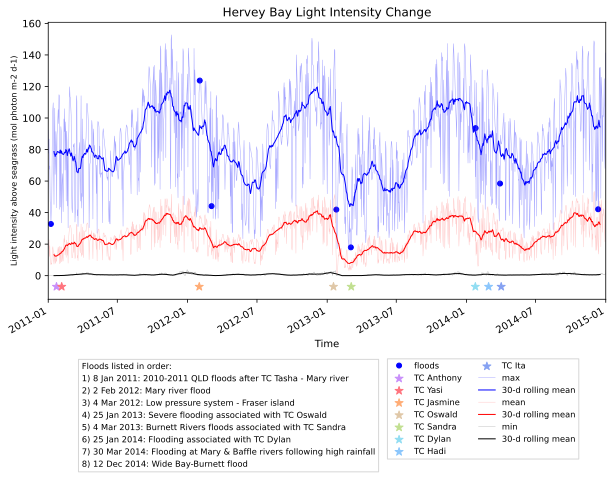

In [36]:
cycFloodPlot('Hervey bay', variable_name='light')

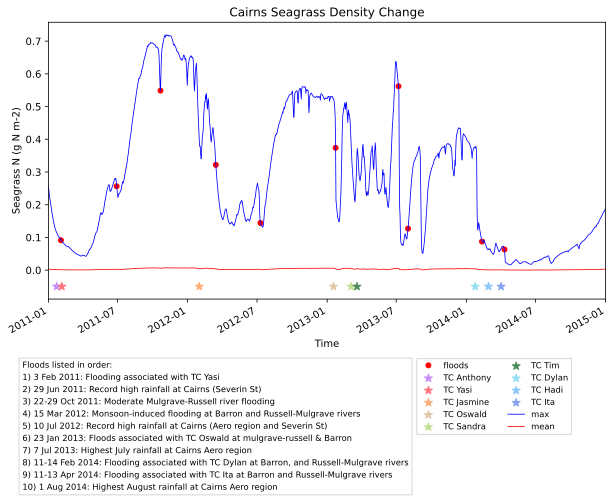

In [24]:
cycFloodPlot('Cairns', variable_name='seagrass')

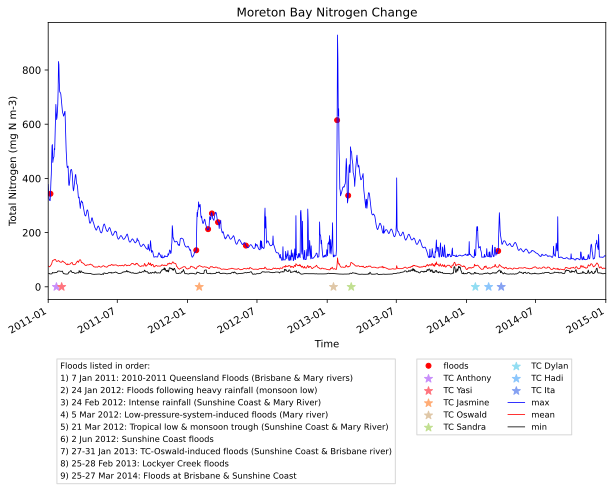

In [15]:
cycFloodPlot('Moreton bay', variable_name='nitrogen')

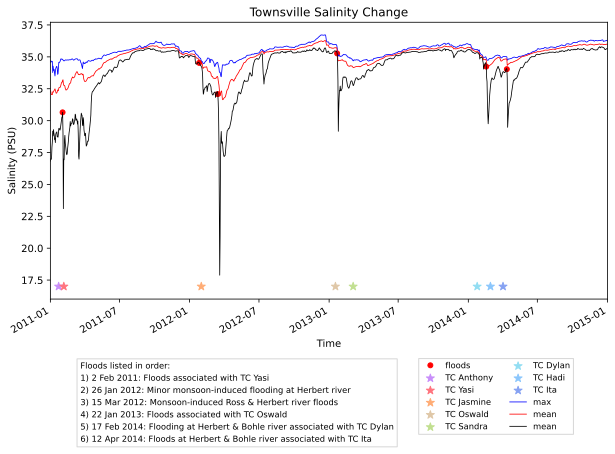

In [24]:
cycFloodPlot('Townsville', variable_name='salinity')

Below is the code to create a multi-panel figure for Hervey bay containing all the variables and the relevant cyclone and flood impact. First we create the cyclone dataframe relevant to Hervey bay. This section of the code does not need to be repeated if it is already running from previously.

In [102]:
cyclones = {
'cyc_name': ['TC Anthony', 'TC Yasi', 'TC Jasmine', 'TC Oswald', 'TC Sandra', 'TC Dylan', 'TC Hadi', 'TC Ita'],
'cyc_x': [Anthony["ISO_TIME"][0], # We plot at the recorded beginning of the cyclone
            Yasi["ISO_TIME"][-1], # Since TCs Anthony and Yasi overlap, we plot the last recorded time of Yasi instead
            Jasmine["ISO_TIME"][0], 
            Oswald["ISO_TIME"][0],
            Sandra["ISO_TIME"][0], 
            Dylan["ISO_TIME"][0], 
            Hadi["ISO_TIME"][0], 
            Ita["ISO_TIME"][0]],
'cyc_y': [-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1], # y-values; we will plot cyclones at the bottom of y-axis
'cyc_y_salinity': [-1,-1,-1,-1,-1,-1,-1,-1], # the y values need to be a little lower for light and salinity
'cyc_y_light': [-7,-7,-7,-7,-7,-7,-7,-7],
}
    
# We make this into a dataframe
cyc_df = pd.DataFrame(herveyBay_cyclones, columns = ['cyc_name', 'cyc_x', 'cyc_y', 'cyc_y_salinity', 'cyc_y_light'])

Then we plot the multi-panel figure:

/tmp/ipykernel_262/2839940981.py:83: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f2134f72290> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax4.legend(['floods', '_nolegend_', '_nolegend_', '_nolegend_','_nolegend_','_nolegend_','_nolegend_',
/tmp/ipykernel_262/2839940981.py:83: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f2134f72740> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax4.legend(['floods', '_nolegend_', '_nolegend_', '_nolegend_','_nolegend_','_nolegend_','_nolegend_',
/tmp/ipykernel_262/2839940981.py:83: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f2134f72bf0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax4.legend(['floods', '_nolegend_', '_nolegend_', '_nolegend_','_nolegend_','_nolegend_','_nolegend_',
/tmp/ipykernel_262/2839940981.py:83: UserWarning: The handle <matplotl

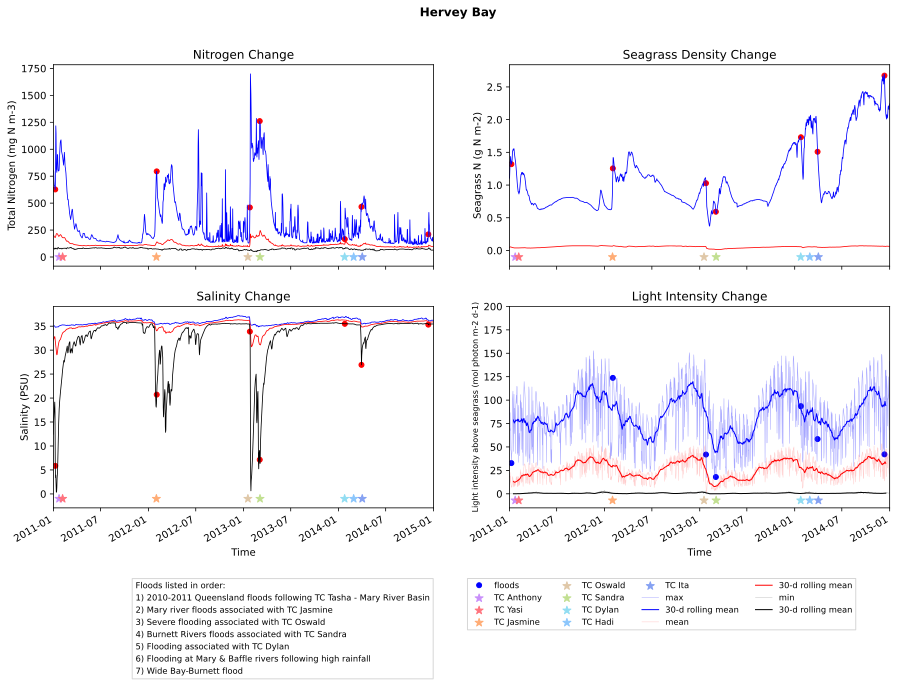

In [119]:
# Setting up a multi-panel 2x2 figure with four subplots for our variables and setting the title
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,sharex=True, figsize=(15, 8))
fig.suptitle('Hervey Bay', weight='bold')

# Creating a list of the relevant floods to add as a legend below the plot later
HerveyBay_floodList = ['Floods listed in order:',
                        '1) 8 Jan 2011: 2010-2011 QLD floods after TC Tasha - Mary river',
                        '2) 2 Feb 2012: Mary river flood',
                        '3) 4 Mar 2012: Low pressure system - Fraser island'
                        '3) 25 Jan 2013: Severe flooding associated with TC Oswald',
                        '4) 4 Mar 2013: Burnett Rivers floods associated with TC Sandra',
                        '5) 25 Jan 2014: Flooding associated with TC Dylan',
                        '6) 30 Mar 2014: Flooding at Mary & Baffle rivers following high rainfall',
                        '7) 12 Dec 2014: Wide Bay-Burnett flood']
    
# Plotting the floods on a each subplot with the relevant y-values
ax1.plot(HerveyFloods.time, HerveyFloods.TOTAL_NITROGEN, 'o', color='r', label='floods', markersize=5, zorder=0)
ax2.plot(HerveyFloods.time, HerveyFloods.seagrass, 'o', color='r', label='floods', markersize=5, zorder=0)           
ax3.plot(HerveyFloods.time, HerveyFloods.salinity, 'o', color='r', label='floods', markersize=5, zorder=0)           
ax4.plot(HerveyFloods.time, HerveyFloods.light, 'o', color='b', label='floods', markersize=5, zorder=0)           

# Plotting the incidence of each relevant cyclone at the bottom of the plot
for cyc_name in list(herveyCyc_df['cyc_name'].unique()):
    ax1.scatter(herveyCyc_df[herveyCyc_df['cyc_name'] == cyc_name]['cyc_x'],
                herveyCyc_df[herveyCyc_df['cyc_name'] == cyc_name]['cyc_y'],
                s = 70,
                marker = '*', label = cyc_name,
                facecolors = colors[cyc_name])
for cyc_name in list(herveyCyc_df['cyc_name'].unique()):
    ax2.scatter(herveyCyc_df[herveyCyc_df['cyc_name'] == cyc_name]['cyc_x'],
                herveyCyc_df[herveyCyc_df['cyc_name'] == cyc_name]['cyc_y'],
                s = 70,
                marker = '*', label = cyc_name,
                facecolors = colors[cyc_name])
for cyc_name in list(herveyCyc_df['cyc_name'].unique()):
    ax3.scatter(herveyCyc_df[herveyCyc_df['cyc_name'] == cyc_name]['cyc_x'],
                herveyCyc_df[herveyCyc_df['cyc_name'] == cyc_name]['cyc_y_salinity'],
                s = 70,
                marker = '*', label = cyc_name,
                facecolors = colors[cyc_name])
for cyc_name in list(herveyCyc_df['cyc_name'].unique()):
    ax4.scatter(herveyCyc_df[herveyCyc_df['cyc_name'] == cyc_name]['cyc_x'],
                herveyCyc_df[herveyCyc_df['cyc_name'] == cyc_name]['cyc_y_light'],
                s = 70,
                marker = '*', label = cyc_name,
                facecolors = colors[cyc_name])

# Plotting min mean and max total nitrogen values
max_region.TOTAL_NITROGEN.plot(ax=ax1, lw=0.8, color="blue", label='max', zorder=1) # 1 zorder plots above the cyclone and flood plots
mean_region.TOTAL_NITROGEN.plot(ax=ax1, lw=0.8, color="red", label='mean', zorder=1)
min_region.TOTAL_NITROGEN.plot(ax=ax1, lw=0.8, color="k", label='min', zorder=1)

# Plotting mean and max seagrass density values
max_region.seagrass.plot(ax=ax2, lw=0.8, color="blue", label='max', zorder=1) 
mean_region.seagrass.plot(ax=ax2, lw=0.8, color="red", label='mean', zorder=1)
    
# Plotting min, mean and max salinity values
max_region.salinity.plot(ax=ax3, lw=0.8, color="blue",label='max', zorder=1)
mean_region.salinity.plot(ax=ax3, lw=0.8, color="red",label='mean', zorder=1)
min_region.salinity.plot(ax=ax3, lw=0.8, color="k",label='mean', zorder=1)

# Plotting min, mean and max light intensity values with rolling means
max_region.light.plot(ax=ax4, lw=0.5, alpha=0.5,color="#4d4dff",label='max', zorder=1) 
month_max_region.light.plot(ax=ax4, lw=1, color="blue",label='30-d rolling mean', zorder=1)
mean_region.light.plot(ax=ax4, lw=0.5, alpha=0.2,color="r",label='mean', zorder=1)
month_mean_region.light.plot(ax=ax4, lw=1, color="red",label='30-d rolling mean', zorder=1)
min_region.light.plot(ax=ax4, lw=0.5, alpha=0.5, color="grey",label='min', zorder=1)
month_min_region.light.plot(ax=ax4, lw=1, color="k",label='30-d rolling mean', zorder=1)

# Setting x and y limits. For light intensity, we need more space along the y-axis for our legend and cyclones
plt.xlim([datetime.date(2011, 1, 1), datetime.date(2015, 1, 1)])
ax4.set_ylim(-15, 200)

# Adding axis labels and titles and adding a legend for light intensity
ax1.set_ylabel("Total Nitrogen (mg N m-3)", color="k")
ax1.set_xlabel('') # The label is left blank as it is shared with the plot below it and thus not needed
ax1.set_title('Nitrogen Change')

ax2.set_ylabel("Seagrass N (g N m-2)", color="k")
ax2.set_xlabel('') # The label is left blank as it is shared with the plot below it and thus not needed
ax2.set_title('Seagrass Density Change')

ax3.set_ylabel("Salinity (PSU)", color="k")
ax3.set_title('Salinity Change')

ax4.set_xlabel("Time", color="k")
ax4.set_ylabel("Light intensity above seagrass (mol photon m-2 d-1)", color="k", fontsize='8')
# We use '_nolegend_' where we want to hide the legend item since this plot only requires some of the legend items
ax4.legend(['floods', '_nolegend_', '_nolegend_', '_nolegend_','_nolegend_','_nolegend_','_nolegend_',
            '_nolegend_','_nolegend_', 'max', '30-d rolling mean', 'mean', 
            '30-d rolling mean', 'min', '30-d rolling mean'], loc=2, fontsize='small', ncol=3)
ax4.set_title('Light Intensity Change')

# We get the handles and labels for the salinity flood legend as it includes all the important information
ax3.get_legend_handles_labels()

leg = plt.legend(HerveyBay_floodList, loc='center right', bbox_to_anchor=(-0.19, -0.6),handlelength=0,
                         handletextpad=0,fancybox=False, shadow=False, ncol=1, fontsize='small')

# The legend handles are set to invisible so it just displays the legend as text
for item in leg.legendHandles:
    item.set_visible(False)
    
# A second legend is added below the figure containing all plotted keys 
plt.legend(loc='upper center', bbox_to_anchor=(0.4, -0.33),fancybox=False, shadow=False, ncol=4, fontsize='small')
    
# The list of floods is also added as a legend below the figure
plt.gca().add_artist(leg)

plt.savefig('test', dpi=300, bbox_inches='tight')

Below is a custom function that plots a multi-panel figure with all variables for the specified site:

In [24]:
def cycFloodPlot_multi(site_name):

    '''
    This function plots the incidence of cyclones and floods beneath time series of a specified variables for a 
    specified site
    
    args:
    - site_name: the name of the site plotted, e.g. Hervey bay
    '''
    
    # Convert the specified variable name to lower case and capitalise only the first letter of the site name
    sName_cap = site_name.capitalize()
    
    # Using the specified site name to get the required datasets
    if sName_cap == 'Cairns':
        site_ds = Cairns_ds
        floodmerge = CairnsFloods
    elif sName_cap == 'Townsville':
        site_ds = Townsville_ds
        floodmerge = TownsvilleFloods
    elif sName_cap == 'Hervey bay':
        site_ds = HerveyBay_ds
        floodmerge = HerveyFloods
    elif sName_cap == 'Moreton bay':
        site_ds = MoretonBay_ds  
        floodmerge = MoretonFloods
    
    # Compute min, mean and max values and rolling means
    max_region = site_ds.max(dim=('latitude', 'longitude'))
    month_max_region = max_region.rolling(time=30,center=True).mean() # 30-day interval
    min_region = site_ds.min(dim=('latitude', 'longitude'))
    month_min_region = min_region.rolling(time=30,center=True).mean()
    mean_region = site_ds.mean(dim=('latitude', 'longitude'))
    month_mean_region = mean_region.rolling(time=30,center=True).mean()

    # Assign colours to each cyclone to distinguish markers
    colors = {'TC Anthony': '#c88efa', 'TC Yasi': '#ff737d', 'TC Jasmine': '#ffac75', 'TC Oswald': '#dfc7a7', 
              'TC Sandra': '#c1df90', 'TC Tim': '#4D8C57', 'TC Dylan': '#91DDF2', 'TC Hadi': '#8BC6FC', 'TC Ita': '#85A1F2'}
   
    # Creat a dictionary with cyclone name and corresponding x and y values for variables
    cyclones = {
    'cyc_name': ['TC Anthony', 'TC Yasi', 'TC Jasmine', 'TC Oswald', 'TC Sandra', 'TC Dylan', 'TC Hadi', 'TC Ita'],
    'cyc_x': [Anthony["ISO_TIME"][0], # We plot at the recorded beginning of the cyclone
              Yasi["ISO_TIME"][-1], # Since TCs Anthony and Yasi overlap, we plot the last recorded time of Yasi instead
              Jasmine["ISO_TIME"][0], 
              Oswald["ISO_TIME"][0],
              Sandra["ISO_TIME"][0], 
              Dylan["ISO_TIME"][0], 
              Hadi["ISO_TIME"][0], 
              Ita["ISO_TIME"][0]],
    'cyc_y': [-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1], # y-values; we will plot cyclones at the bottom of y-axis
    'cyc_y_salinity': [-1,-1,-1,-1,-1,-1,-1,-1], # the y values need to be a little lower for light and salinity
    'cyc_y_light': [-7,-7,-7,-7,-7,-7,-7,-7],
    'cyc_y_nitrogen': [-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1]

    }
    
    # We make this into a dataframe
    cyc_df = pd.DataFrame(cyclones, columns = ['cyc_name', 'cyc_x', 'cyc_y', 'cyc_y_salinity', 
                                               'cyc_y_light', 'cyc_y_nitrogen'])

    # We need to create a separate dataframe for Townsville as there is less variation for salinity 
    # so cyclones can be plotted higher on the y-axis
    Townsville_cyclones = {
    'cyc_name': ['TC Anthony', 'TC Yasi', 'TC Jasmine', 'TC Oswald', 'TC Sandra', 'TC Dylan', 'TC Hadi', 'TC Ita'],
    'cyc_x': [Anthony["ISO_TIME"][0], # We plot at the recorded beginning of the cyclone
              Yasi["ISO_TIME"][-1], # Since TCs Anthony and Yasi overlap, we plot the last recorded time of Yasi instead
              Jasmine["ISO_TIME"][0], 
              Oswald["ISO_TIME"][0],
              Sandra["ISO_TIME"][0], 
              Dylan["ISO_TIME"][0], 
              Hadi["ISO_TIME"][0], 
              Ita["ISO_TIME"][0]],
    'cyc_y': [-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05], # y-values; we will plot cyclones at the bottom of y-axis
    'cyc_y_salinity': [17,17,17,17,17,17,17,17], # the y values need to be a little higher for light and salinity
    'cyc_y_light': [-7,-7,-7,-7,-7,-7,-7,-7],
    'cyc_y_nitrogen': [-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1],
    }
    
    # We make this into a dataframe
    TownsvilleCyc_df = pd.DataFrame(Townsville_cyclones, columns = ['cyc_name', 'cyc_x', 'cyc_y', 'cyc_y_salinity', 'cyc_y_light',
                                                         'cyc_y_nitrogen'])
    
    # We create a separate dictionary for Cairns as it is the only region to be impacted by cyclone Tim
    Cairns_cyclones = {
    'cyc_name': ['TC Anthony', 'TC Yasi', 'TC Jasmine', 'TC Oswald', 'TC Sandra', 'TC Tim', 'TC Dylan', 'TC Hadi', 'TC Ita'],
    'cyc_x': [Anthony["ISO_TIME"][0], # We plot at the recorded beginning of the cyclone
              Yasi["ISO_TIME"][-1], # Since TCs Anthony and Yasi overlap, we plot the last recorded time of Yasi instead
              Jasmine["ISO_TIME"][0], 
              Oswald["ISO_TIME"][0],
              Sandra["ISO_TIME"][0], 
              Tim["ISO_TIME"][-1], # Since TCs Sandra and Tim overlap, we also plot the last recorded time of Tim
              Dylan["ISO_TIME"][0], 
              Hadi["ISO_TIME"][0], 
              Ita["ISO_TIME"][0]],
    'cyc_y': [-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05,-0.05], # y-values; we will plot cyclones at the bottom of y-axis
    'cyc_y_salinity': [20,20,20,20,20,20,20,20,20], # the y values need to be a little higher for nitrogen and salinity
    'cyc_y_light': [-7,-7,-7,-7,-7,-7,-7,-7,-7],
    'cyc_y_nitrogen': [25,25,25,25,25,25,25,25,25],
    }
    
    # We make this into a dataframe
    CairnsCyc_df = pd.DataFrame(Cairns_cyclones, columns = ['cyc_name', 'cyc_x', 'cyc_y', 'cyc_y_salinity', 
                                                            'cyc_y_light', 'cyc_y_nitrogen'])
    
    # Create a list of all the relevant floods for each region
    Cairns_floodList = ['Floods listed in order:', '1) 3 Feb 2011: Flooding associated with TC Yasi',
                        '2) 29 Jun 2011: Record high rainfall at Cairns (Severin St)',
                        '3) 22-29 Oct 2011: Moderate Mulgrave-Russell river flooding',
                        '4) 15 Mar 2012: Monsoon-induced flooding at Barron and Russell-Mulgrave rivers',
                        '5) 10 Jul 2012: Record high rainfall at Cairns (Aero region and Severin St)',
                        '6) 23 Jan 2013: Floods associated with TC Oswald at mulgrave-russell & Barron',
                        '7) 7 Jul 2013: Highest July rainfall at Cairns Aero region',
                        '8) 11-14 Feb 2014: Flooding associated with TC Dylan at Barron, and Russell-Mulgrave rivers',
                        '9) 11-13 Apr 2014: Flooding associated with TC Ita at Barron and Russell-Mulgrave rivers',
                        '10) 1 Aug 2014: Highest August rainfall at Cairns Aero region']
    
    Townsville_floodList = ['Floods listed in order:', 
                            '1) 2 Feb 2011: Floods associated with TC Yasi', 
                            '2) 26 Jan 2012: Minor monsoon-induced flooding at Herbert river', 
                            '3) 15 Mar 2012: Monsoon-induced Ross & Herbert river floods', 
                            '4) 22 Jan 2013: Floods associated with TC Oswald', 
                            '5) 17 Feb 2014: Flooding at Herbert & Bohle river associated with TC Dylan',
                            '6) 12 Apr 2014: Floods at Herbert & Bohle river associated with TC Ita']
    
    HerveyBay_floodList = ['Floods listed in order:',
                           '1) 8 Jan 2011: 2010-2011 QLD floods after TC Tasha - Mary river',
                           '2) 2 Feb 2012: Mary river flood',
                           '3) 4 Mar 2012: Low pressure system - Fraser island',
                           '4) 25 Jan 2013: Severe flooding associated with TC Oswald',
                           '5) 4 Mar 2013: Burnett Rivers floods associated with TC Sandra',
                           '6) 25 Jan 2014: Flooding associated with TC Dylan',
                           '7) 30 Mar 2014: Flooding at Mary & Baffle rivers following high rainfall',
                           '8) 12 Dec 2014: Wide Bay-Burnett flood']
    
    MoretonBay_floodList = ['Floods listed in order:',
                            '1) 7 Jan 2011: 2010-2011 Queensland Floods (Brisbane & Mary rivers)',
                            '2) 24 Jan 2012: Floods following heavy rainfall (monsoon low)',
                            '3) 24 Feb 2012: Intense rainfall (Sunshine Coast & Mary River)',
                            '4) 5 Mar 2012: Low-pressure-system-induced floods (Mary river)',
                            '5) 21 Mar 2012: Tropical low & monsoon trough (Sunshine Coast & Mary River)',
                            '6) 2 Jun 2012: Sunshine Coast floods',
                            '7) 27-31 Jan 2013: TC-Oswald-induced floods (Sunshine Coast & Brisbane river)',
                            '8) 25-28 Feb 2013: Lockyer Creek floods',
                            '9) 25-27 Mar 2014: Floods at Brisbane & Sunshine Coast']    
    
    # Setting up a multi-panel 2x2 figure with four subplots for our variables and setting the title
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,sharex=True, figsize=(15, 8))
    fig.suptitle(str(site_name.title()), weight='bold')
    
    # Plot floods at corresponding y-values for the specified variable
    ax1.plot(floodmerge.time, floodmerge.TOTAL_NITROGEN, 'o', color='r', label='floods', markersize=4.5, zorder=0)
    ax2.plot(floodmerge.time, floodmerge.seagrass, 'o', color='r', label='floods', markersize=4.5, zorder=0)           
    ax3.plot(floodmerge.time, floodmerge.salinity, 'o', color='r', label='floods', markersize=4.5, zorder=0)           
    ax4.plot(floodmerge.time, floodmerge.light, 'o', color='b', label='floods', markersize=4.5, zorder=0)           

    # Plot cyclones relevant to specified region at the bottom along the x-axis with colours to distinguish each cyclone
    if sName_cap == 'Townsville':
        siteCyc_data = TownsvilleCyc_df
    elif sName_cap == 'Cairns':
          siteCyc_data = CairnsCyc_df
    else:
        siteCyc_data = cyc_df
    for cyc_name in list(siteCyc_data['cyc_name'].unique()):
        ax1.scatter(siteCyc_data[siteCyc_data['cyc_name'] == cyc_name]['cyc_x'],
                    siteCyc_data[siteCyc_data['cyc_name'] == cyc_name]['cyc_y_nitrogen'],
                    s = 65,
                    marker = '*', label = cyc_name,
                    facecolors = colors[cyc_name])
        ax2.scatter(siteCyc_data[siteCyc_data['cyc_name'] == cyc_name]['cyc_x'],
                    siteCyc_data[siteCyc_data['cyc_name'] == cyc_name]['cyc_y'],
                    s = 65,
                    marker = '*', label = cyc_name,
                    facecolors = colors[cyc_name])
        ax3.scatter(siteCyc_data[siteCyc_data['cyc_name'] == cyc_name]['cyc_x'],
                    siteCyc_data[siteCyc_data['cyc_name'] == cyc_name]['cyc_y_salinity'],
                    s = 65,
                    marker = '*', label = cyc_name,
                    facecolors = colors[cyc_name])
        ax4.scatter(siteCyc_data[siteCyc_data['cyc_name'] == cyc_name]['cyc_x'],
                    siteCyc_data[siteCyc_data['cyc_name'] == cyc_name]['cyc_y_light'],
                    s = 65,
                    marker = '*', label = cyc_name,
                    facecolors = colors[cyc_name])

    # Plotting the variable data:
    # Plotting min, mean and max total nitrogen values
    max_region.TOTAL_NITROGEN.plot(ax=ax1, lw=0.8, color="blue", label='max', zorder=1) # 1 zorder plots above the cyclone and flood plots
    mean_region.TOTAL_NITROGEN.plot(ax=ax1, lw=0.8, color="red", label='mean', zorder=1)
    min_region.TOTAL_NITROGEN.plot(ax=ax1, lw=0.8, color="k", label='min', zorder=1)
                                                                       
    # Plotting mean and max seagrass density values
    max_region.seagrass.plot(ax=ax2, lw=0.8, color="blue", label='max', zorder=1) 
    mean_region.seagrass.plot(ax=ax2, lw=0.8, color="red", label='mean', zorder=1) 
                                                                       
    # Plotting min, mean and max salinity values
    max_region.salinity.plot(ax=ax3, lw=0.8, color="blue",label='max', zorder=1)
    mean_region.salinity.plot(ax=ax3, lw=0.8, color="red",label='mean', zorder=1)
    min_region.salinity.plot(ax=ax3, lw=0.8, color="k",label='mean', zorder=1)
 
    # Plotting min, mean and max light intensity values with rolling means
    max_region.light.plot(ax=ax4, lw=0.5, alpha=0.5,color="#4d4dff",label='max', zorder=1) 
    month_max_region.light.plot(ax=ax4, lw=1, color="blue",label='30-d rolling mean', zorder=1)
    mean_region.light.plot(ax=ax4, lw=0.5, alpha=0.2,color="r",label='mean', zorder=1)
    month_mean_region.light.plot(ax=ax4, lw=1, color="red",label='30-d rolling mean', zorder=1)
    min_region.light.plot(ax=ax4, lw=0.5, alpha=0.5, color="grey",label='min', zorder=1)
    month_min_region.light.plot(ax=ax4, lw=1, color="k",label='30-d rolling mean', zorder=1)

    #setting the x-axis limit to use all available space
    plt.xlim([datetime.date(2011, 1, 1), datetime.date(2015, 1, 1)])
    
    # Extending the y-axis to provide more space to plot cyclones and the legend
    if sName_cap == 'Cairns':
        ax4.set_ylim(-15, 150) # Less space is needed along the y-axis on this light intensity plot for Cairns legend
    elif sName_cap == 'Moreton bay':
        ax4.set_ylim(-15, 175) # Less space is needed for Moreton bay as well
    else:
        ax4.set_ylim(-15, 200)

    # Adding axis labels, legend and title and saving the figure.
    ax1.set_ylabel("Total Nitrogen (mg N m-3)", color="k")
    ax1.set_title('Nitrogen Change')
    ax1.set_xlabel('') # The label is left blank as it is shared with the plot below it and thus not needed
    
    ax2.set_ylabel("Seagrass N (g N m-2)", color="k")
    ax2.set_title('Seagrass Density Change')
    ax2.set_xlabel('')
    
    ax3.set_ylabel("Salinity (PSU)", color="k")
    ax3.set_title('Salinity Change')
    ax3.set_xlabel('Time', color='k')
    
    ax4.set_ylabel("Light intensity above seagrass (mol photon m-2 d-1)", color="k", fontsize='8')
    ax4.set_title('Light Intensity Change')
    ax4.set_xlabel('Time', color='k')
    
    # The legend for light intensity is added within the figure with only the relevant items
    ax4.get_legend_handles_labels()
    # Cairns is the only site that includes cyclone Tim so we will need to add an extra empty label to this legend
    if sName_cap == 'Cairns':
        light_legend = ax4.legend(['floods', '_nolegend_', '_nolegend_', '_nolegend_','_nolegend_','_nolegend_','_nolegend_',
                                   '_nolegend_', '_nolegend_', '_nolegend_', 'max', '30-d rolling mean', 'mean',
                                   '30-d rolling mean', 'min', '30-d rolling mean'], loc=2, fontsize='small', ncol=3)
    else:
        light_legend = ax4.legend(['floods', '_nolegend_', '_nolegend_', '_nolegend_','_nolegend_','_nolegend_','_nolegend_',
                                   '_nolegend_','_nolegend_', 'max', '30-d rolling mean', 'mean',
                                   '30-d rolling mean', 'min', '30-d rolling mean'], loc=2, fontsize='small', ncol=3)
    
    # Getting the handles and labels for our legend
    ax3.get_legend_handles_labels()

    # A legend is created containing a list of the plotted floods for the specified site 
    if sName_cap == 'Cairns':
        leg = plt.legend(Cairns_floodList, loc='center right', bbox_to_anchor=(0.1, -0.66),handlelength=0,
                         handletextpad=0,fancybox=False, shadow=False, ncol=1, fontsize='small')
    elif sName_cap == 'Townsville':
        leg = plt.legend(Townsville_floodList, loc='center right', bbox_to_anchor=(0.08, -0.54),handlelength=0,
                         handletextpad=0,fancybox=False, shadow=False, ncol=1, fontsize='small')
    elif sName_cap == 'Hervey bay':
        leg = plt.legend(HerveyBay_floodList, loc='center right', bbox_to_anchor=(0.09, -0.6),handlelength=0,
                         handletextpad=0,fancybox=False, shadow=False, ncol=1, fontsize='small')
    elif sName_cap == 'Moreton bay':
        leg = plt.legend(MoretonBay_floodList, loc='center right', bbox_to_anchor=(0.1, -0.63),handlelength=0,
                         handletextpad=0,fancybox=False, shadow=False, ncol=1, fontsize='small')
    for item in leg.legendHandles:
        item.set_visible(False)
    
    # A second legend is added below the figure containing all plotted keys 
    ax3.legend(loc='upper center', bbox_to_anchor=(1.5, -0.3),fancybox=False, shadow=False, ncol=2, fontsize='small')
    
    # The list of floods is also added as a legend below the figure
    plt.gca().add_artist(leg)
    plt.gca().add_artist(light_legend)

    plt.savefig(str(site_name)+' Multi-Panel Time Series', dpi=300, bbox_inches='tight')

    plt.show()


Calling the function:

/tmp/ipykernel_87/2080416065.py:245: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7fd42f411600> has a label of '_nolegend_' which cannot be automatically added to the legend.
  light_legend = ax4.legend(['floods', '_nolegend_', '_nolegend_', '_nolegend_','_nolegend_','_nolegend_','_nolegend_',
/tmp/ipykernel_87/2080416065.py:245: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7fd42f412470> has a label of '_nolegend_' which cannot be automatically added to the legend.
  light_legend = ax4.legend(['floods', '_nolegend_', '_nolegend_', '_nolegend_','_nolegend_','_nolegend_','_nolegend_',
/tmp/ipykernel_87/2080416065.py:245: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7fd42f516da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  light_legend = ax4.legend(['floods', '_nolegend_', '_nolegend_', '_nolegend_','_nolegend_','_nolegend_','_nolegend_',
/tmp/ipykernel_87/2080416

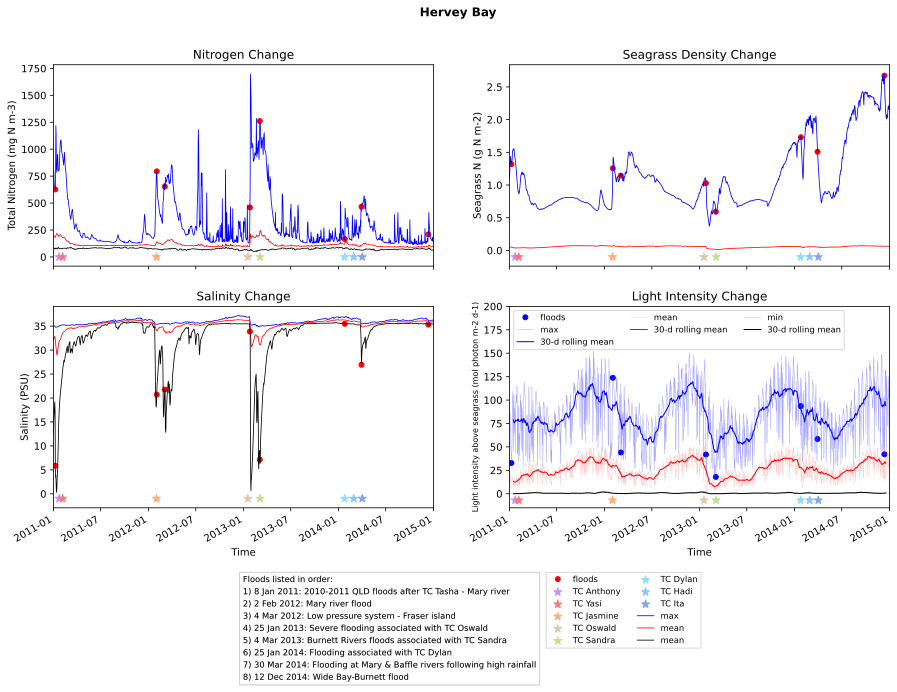

In [44]:
cycFloodPlot_multi('Hervey Bay')

/tmp/ipykernel_93/3433803747.py:241: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f20e5510760> has a label of '_nolegend_' which cannot be automatically added to the legend.
  light_legend = ax4.legend(['floods', '_nolegend_', '_nolegend_', '_nolegend_','_nolegend_','_nolegend_','_nolegend_',
/tmp/ipykernel_93/3433803747.py:241: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f20e5511750> has a label of '_nolegend_' which cannot be automatically added to the legend.
  light_legend = ax4.legend(['floods', '_nolegend_', '_nolegend_', '_nolegend_','_nolegend_','_nolegend_','_nolegend_',
/tmp/ipykernel_93/3433803747.py:241: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f20e5512a10> has a label of '_nolegend_' which cannot be automatically added to the legend.
  light_legend = ax4.legend(['floods', '_nolegend_', '_nolegend_', '_nolegend_','_nolegend_','_nolegend_','_nolegend_',
/tmp/ipykernel_93/3433803

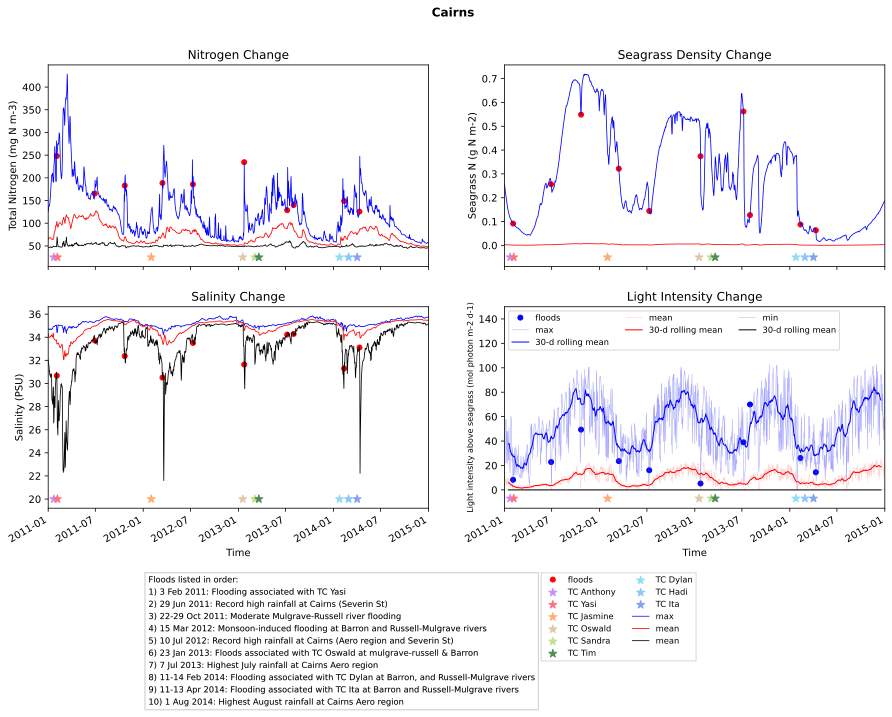

In [22]:
cycFloodPlot_multi('Cairns')

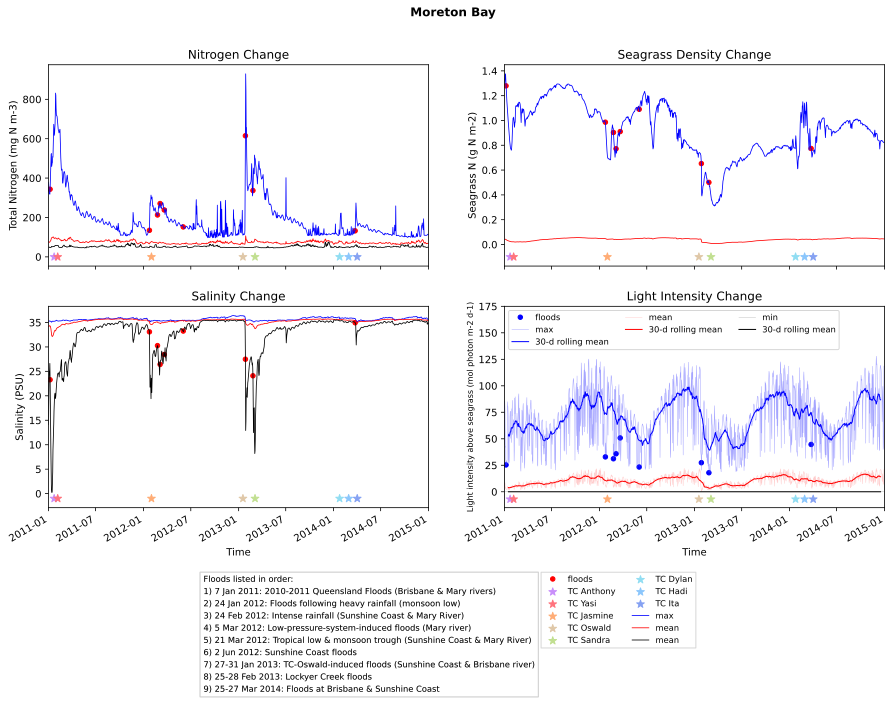

In [25]:
cycFloodPlot_multi('Moreton bay')

/tmp/ipykernel_92/3433803747.py:245: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f06fd9d5120> has a label of '_nolegend_' which cannot be automatically added to the legend.
  light_legend = ax4.legend(['floods', '_nolegend_', '_nolegend_', '_nolegend_','_nolegend_','_nolegend_','_nolegend_',
/tmp/ipykernel_92/3433803747.py:245: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f06fd9d6410> has a label of '_nolegend_' which cannot be automatically added to the legend.
  light_legend = ax4.legend(['floods', '_nolegend_', '_nolegend_', '_nolegend_','_nolegend_','_nolegend_','_nolegend_',
/tmp/ipykernel_92/3433803747.py:245: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f06fd9d7400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  light_legend = ax4.legend(['floods', '_nolegend_', '_nolegend_', '_nolegend_','_nolegend_','_nolegend_','_nolegend_',
/tmp/ipykernel_92/3433803

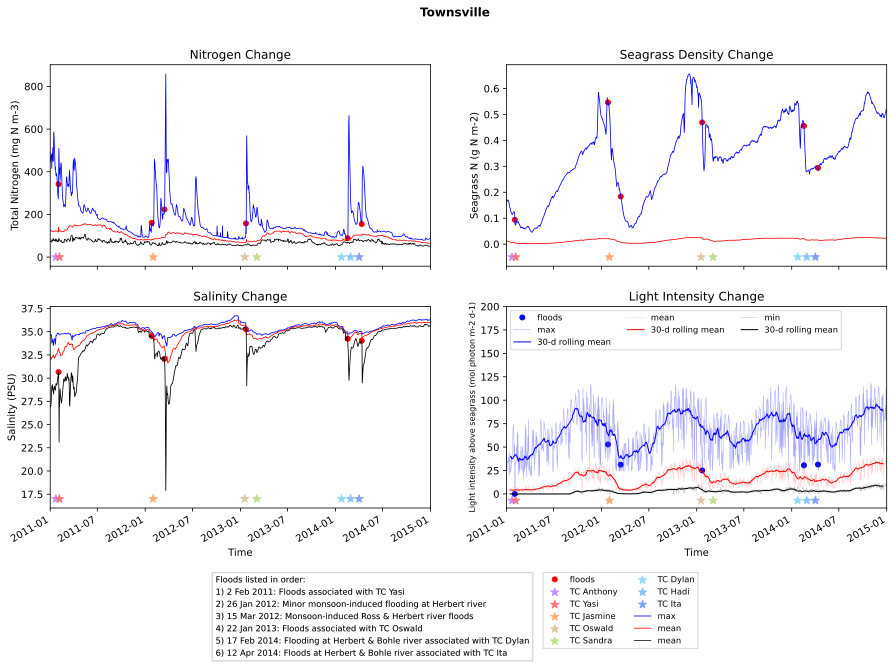

In [22]:
cycFloodPlot_multi('Townsville')